<h1 style='text-align:center;'>Import Modules</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings(action='ignore')
from scipy.stats import norm, probplot, skew
from scipy.special import boxcox1p

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from sklearn.svm import SVR

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

import optuna
from functools import partial

<h1 style='text-align:center;'>Load data</h1>

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [168]:
test2 = pd.read_csv('test.csv')

In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
train.shape, test.shape

((10886, 12), (6493, 9))

<h1 style='text-align:center;'>EDA</h1>

<h2 style='text-align:center;'>1. 종속변수 해석</h2>

count: 종속변수. 연속형 변수<br>


Dependent variable'skew: 1.2420662117180776
Dependent variable'kurt: 1.3000929518398334


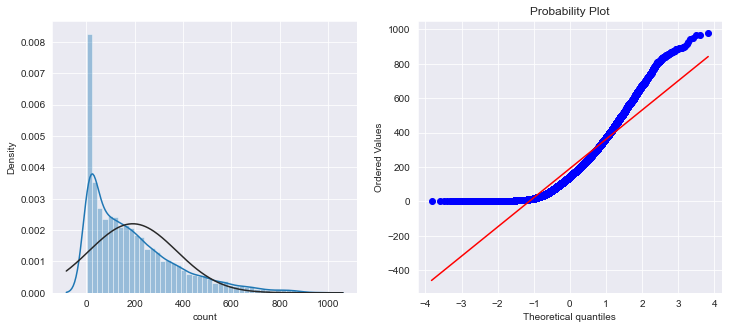

In [6]:
print(f"Dependent variable'skew: {train['count'].skew()}")
print(f"Dependent variable'kurt: {train['count'].kurt()}")
f, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.distplot(train['count'], fit=norm, ax=ax[0])
probplot(train['count'], plot=ax[1])
plt.show()

In [7]:
train['count'].isnull().sum()

0

<font color='red'>conclusion</font>:<br>
종속변수의 왜도가 높고, 히스토그램과 QQ플롯 시각화 결과 정규성을 가지지 않는다. 따라서 로그변환 등 변환 작업이 필요해보인다.<br>
종속변수의 결측치는 존재하지 않는다.

<h2 style='text-align:center;'>2. 독립변수 해석 - 타입 정의</h2>
datetime: 날짜 + 시간 => 시계열 변수<br>
season: 계절. 등간변수<br>
holiday: 공휴일 유무. 이진변수 => 라벨인코딩<br>
workingday: 주간유무. 이진변수 => 라벨인코딩<br>
weather: 날씨. 등간변수<br>
temp: 온도. 연속형 변수<br>
atemp: 체감온도. 연속형 변수<br>
humidity: 습도. 연속형 변수<br>
windspeed: 풍속. 연속형 변수<br>
casual: 등록되지않은 유저의 렌탈횟수. 연속형 변수<br>
registerd: 등록된 유저의 렌탈횟수. 연속형 변수<br><br>
+datetime은 날짜 변수이다. 날짜변수는 년, 월, 일, 시간 등 다양한 변수들로 분해할 수 있기 때문에 미리 변환을 하는 것이 좋다.

In [9]:
train['year'] = train.datetime.apply(lambda x: x.split()[0].split('-')[0])
train['month'] = train.datetime.apply(lambda x: x.split()[0].split('-')[1])
train['weekday'] = train.datetime.apply(lambda x: pd.to_datetime(x.split()[0]))
train['weekday'] = pd.to_datetime(train['weekday']).dt.weekday
train['hour'] = train.datetime.apply(lambda x: x.split()[1].split(':')[0])
#train['minute'] = train.datetime.apply(lambda x: x.split()[1].split(':')[1])
#train['second'] = train.datetime.apply(lambda x: x.split()[1].split(':')[2])

In [10]:
test['year'] = test.datetime.apply(lambda x: x.split()[0].split('-')[0])
test['month'] = test.datetime.apply(lambda x: x.split()[0].split('-')[1])
test['weekday'] = test.datetime.apply(lambda x: pd.to_datetime(x.split()[0]))
test['weekday'] = pd.to_datetime(test['weekday']).dt.weekday
test['hour'] = test.datetime.apply(lambda x: x.split()[1].split(':')[0])
#train['minute'] = train.datetime.apply(lambda x: x.split()[1].split(':')[1])
#train['second'] = train.datetime.apply(lambda x: x.split()[1].split(':')[2])

In [10]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,01,01,5,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,01,01,5,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,01,01,5,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,01,01,5,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,01,01,5,04


In [11]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,weekday,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,01,20,3,00
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,01,20,3,01
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,01,20,3,02
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,01,20,3,03
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,01,20,3,04


In [12]:
nominal_vars = [
]

In [11]:
order_vars = [
    'season', 'weather', 'year', 'month', 'weekday', 'hour', 'holiday', 'workingday'
]

In [12]:
continuous_vars = [
    'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered'
]

In [15]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,01,01,5,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,01,01,5,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,01,01,5,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,01,01,5,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,01,01,5,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,2,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,2,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,2,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,2,22


<h2 style='text-align:center;'>3. 결측치 확인</h2>

In [16]:
all_data = pd.concat((train, test), axis=0).drop(['count'], axis=1)
all_data.columns[all_data.isnull().sum().sort_values(ascending=False) > 0].values

array(['datetime', 'season'], dtype=object)

<h2 style='text-align:center;'>4. 독립변수 해석 - 분포 보기</h2>

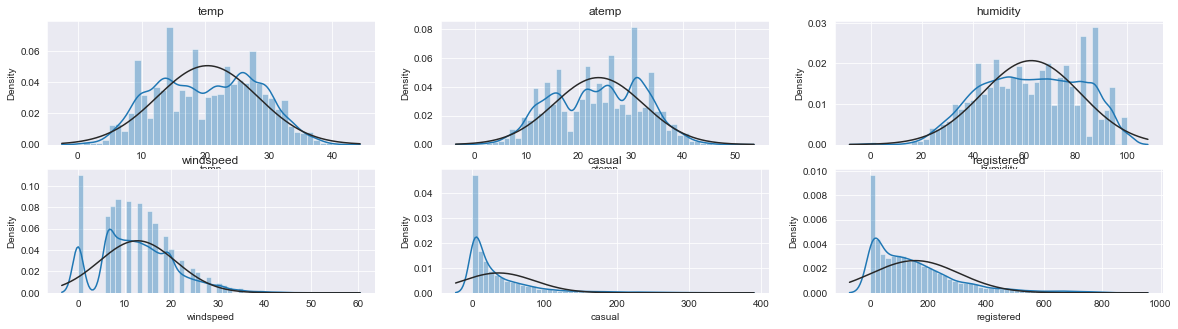

In [17]:
f, ax = plt.subplots(2, 3, figsize=(20, 7))
for i, c in enumerate(continuous_vars):
    g = sns.distplot(all_data[c], fit=norm, ax=ax[i//3][i%3])
plt.show()

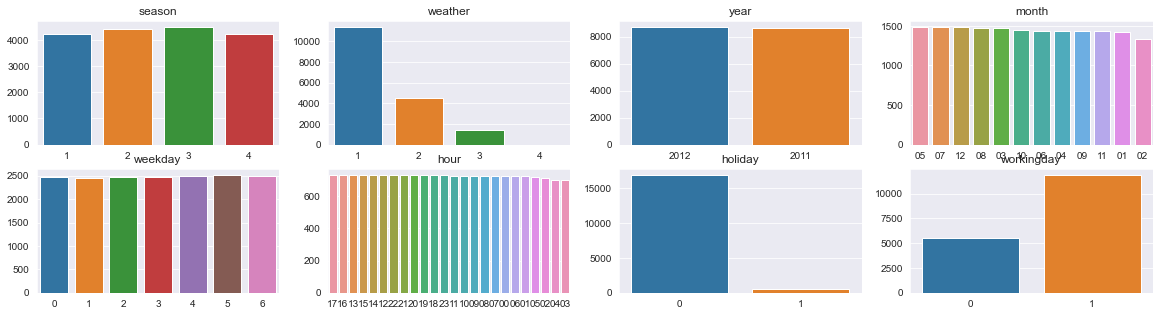

In [18]:
f, ax = plt.subplots(2, 4, figsize=(20, 5))
for i, c in enumerate(nominal_vars + order_vars):
    g = sns.barplot(x=all_data[c].value_counts().index, y=all_data[c].value_counts().values, ax=ax[i//4][i%4])
    g.set_title(c)
plt.show()

<h2 style='text-align:center;'>5. 이변량 분석 - 상관분석, 히트맵, 산점도, 히스토그램</h2>

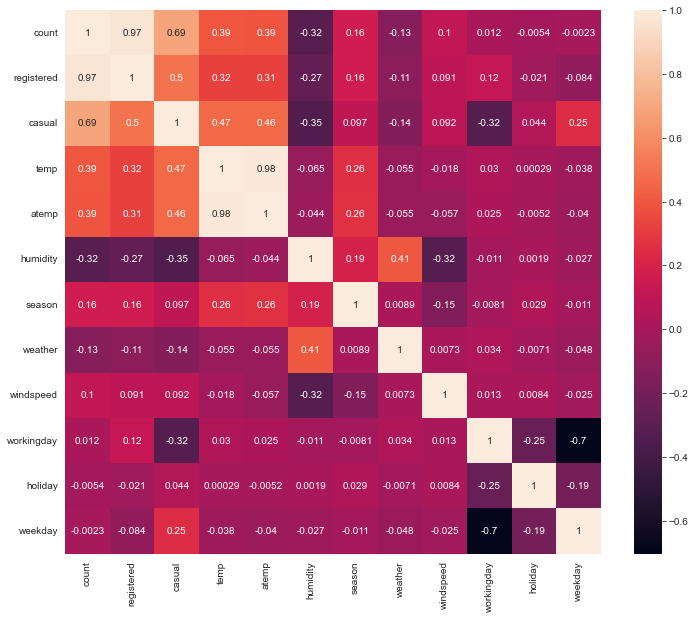

In [19]:
plt.subplots(figsize=(12, 10))
high_vars = abs(train.corr()['count']).sort_values(ascending=False).index
sns.heatmap(train[high_vars].corr(), annot=True)
plt.show()

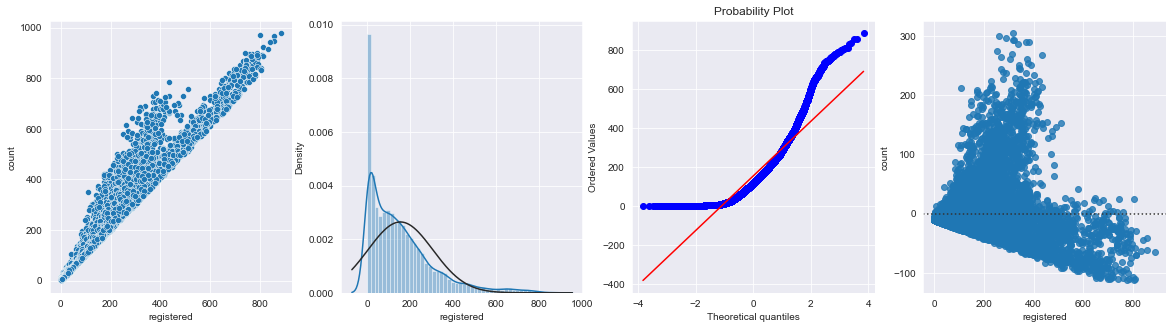

In [20]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(x=train.registered, y=train['count'], ax=ax[0])
sns.distplot(train.registered, fit=norm, ax=ax[1])
probplot(train.registered, plot=ax[2])
sns.residplot(x=train.registered, y=train['count'], ax=ax[3])
plt.show()

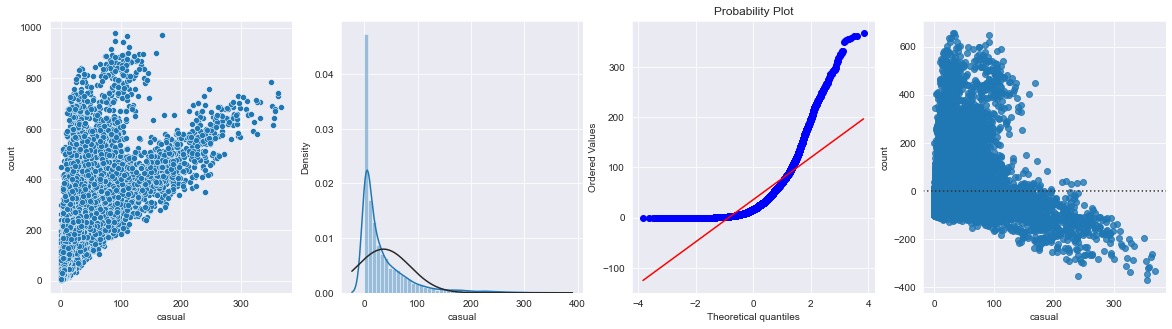

In [21]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.scatterplot(x=train.casual, y=train['count'], ax=ax[0])
sns.distplot(train.casual, fit=norm, ax=ax[1])
probplot(train.casual, plot=ax[2])
sns.residplot(x=train.casual, y=train['count'], ax=ax[3])
plt.show()

종속변수와 상대적으로 선형 상관성이 높은 변수들(registerd, casual)을 대표로 뽑아서 선형성, 정규성, 등분산성을 검정해보았다.<br>
정규성과 등분산성이 만족하지 않아 변환이 필요해보인다.

시간, 계절성 변수가 존재하므로 이들과 종속변수의 관계를 파악해본다.

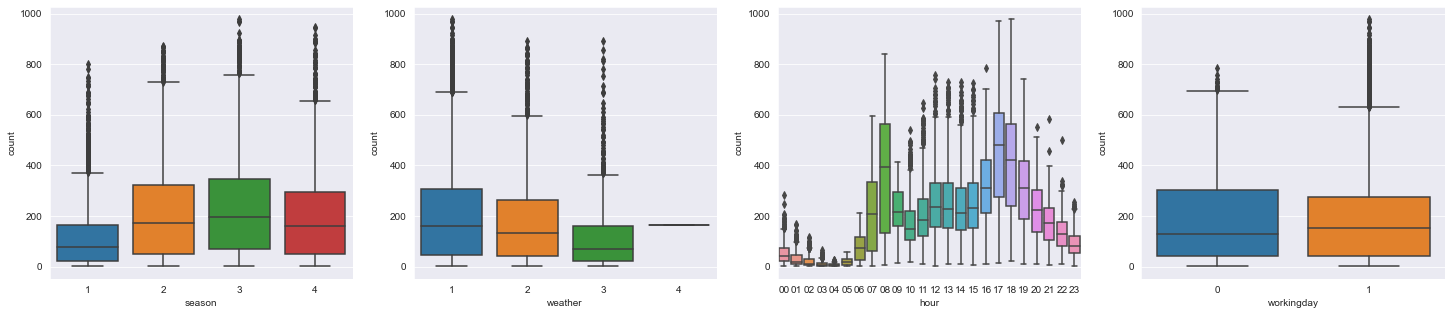

In [22]:
f, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(x=train.season, y=train['count'], ax=ax[0])
sns.boxplot(x=train.weather, y=train['count'], ax=ax[1])
sns.boxplot(x=train.hour, y=train['count'], ax=ax[2])
sns.boxplot(x=train.workingday, y=train['count'], ax=ax[3])
plt.show()

종속변수와 season의 관계: count는 봄에 상대적으로 낮다.<br>
종속변수와 weather의 관계: count는 비가 오는날에 매우 적다.<br>
종속변수와 hour의 관계: 아침시간대와 오후시간대에 가장 높고 평균적으로 일과시간에 높다.<br>
종속변수와 workingday의 관계: 주간이나 휴일이나 큰 차이가 없다.

<h1 style='text-align:center;'>PreProcessing</h1>


<h2 style='text-align:center;'>1. Remove Datetime</h2>

In [13]:
train_datetime = train.datetime
test_datetime = test.datetime
train.drop(['datetime'], axis=1, inplace=True)
test.drop(['datetime'], axis=1, inplace=True)


<h2 style='text-align:center;'>2. Cleansing - outlier</h2>


<h2 style='text-align:center;'>3. Merge train and test, split dependent variable</h2>

In [14]:
train_size = train.shape[0]
y_train = train['count']
all_data = pd.concat((train, test), axis=0).drop(['count'], axis=1)


<h2 style='text-align:center;'>4. Cleansing - missing value</h2>

In [15]:
miss_cnt = all_data.isnull().sum().sort_values(ascending=False)
miss_percent = miss_cnt / all_data.shape[0]
miss_table = pd.DataFrame([miss_cnt, miss_percent], index=['count', 'percent']).T
miss_table = miss_table[miss_table.percent > 0]
miss_table

,count,percent
registered,6493.0,0.373612
casual,6493.0,0.373612


In [16]:
all_data.drop(['casual', 'registered'], axis=1, inplace=True)

In [17]:
continuous_vars = set(continuous_vars) - set(['casual', 'registered'])

In [214]:
all_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,weekday,hour
0,1,0,0,1,9.84,14.395,81,0.0,2011,01,5,00
1,1,0,0,1,9.02,13.635,80,0.0,2011,01,5,01
2,1,0,0,1,9.02,13.635,80,0.0,2011,01,5,02
3,1,0,0,1,9.84,14.395,75,0.0,2011,01,5,03
4,1,0,0,1,9.84,14.395,75,0.0,2011,01,5,04



<h2 style='text-align:center;'>5. 파생변수 생성</h2>

In [27]:
model_rfr = rfr()
cols = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
tmp_X = all_data[all_data.windspeed != 0][cols]
tmp_y = all_data[all_data.windspeed != 0].windspeed
all_data.loc[all_data.windspeed == 0, 'windspeed'] = model_rfr.fit(tmp_X, tmp_y).predict(all_data[all_data.windspeed == 0][cols])


<h2 style='text-align:center;'>6. 변수 선택</h2>

In [234]:
# continuous_vars = set(continuous_vars) - set(['windspeed'])
# order_vars = set(order_vars) - set(['month'])
# all_data.drop(['windspeed', 'month'], axis=1, inplace=True)


<h2 style='text-align:center;'>7. 변수 변환</h2>

In [29]:
for c in continuous_vars:
    if abs(all_data[c].skew()) > 0.5:
        all_data[c] = boxcox1p(all_data[c], 0.15)

In [30]:
le = LabelEncoder()
for c in order_vars:
    all_data[c] = le.fit_transform(all_data[c])

In [31]:
y_train = np.log1p(y_train)

In [32]:
X_train = all_data.iloc[:train_size, :]
X_test = all_data.iloc[train_size:, :]

In [35]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,weekday,hour
0,0,0,0,0,9.84,14.395,81,2.429500,0,0,5,0
1,0,0,0,0,9.02,13.635,80,2.361705,0,0,5,1
2,0,0,0,0,9.02,13.635,80,2.361705,0,0,5,2
3,0,0,0,0,9.84,14.395,75,2.361335,0,0,5,3
4,0,0,0,0,9.84,14.395,75,2.361335,0,0,5,4


In [36]:
X_train.shape, X_test.shape, y_train.shape

((10886, 12), (6493, 12), (10886,))

<h1 style='text-align:center;'>Modeling</h1>

In [33]:
def rmsle(model):
    result = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1))
    return result

In [106]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso())
])
model_elasticNet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(max_iter=5000))
])
model_ridge = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Ridge())
])
model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR())
])

grid_param_lasso = {
    'model__alpha': 0.0001 * np.arange(1, 100)
}
grid_param_elasticNet = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__l1_ratio': 0.001 * np.arange(1, 10)
}
grid_param_ridge = {
    'model__alpha': 0.0001 * np.arange(1, 100)
}
grid_param_svr = {
    'model__C': [11],
    'model__gamma': [0.1],
    'model__epsilon': [0.1]
}


In [71]:
search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params_lasso = search_lasso.best_params_

In [107]:
search_ridge = GridSearchCV(model_ridge, grid_param_lasso, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params_ridge = search_ridge.best_params_

In [72]:
search_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params_elasticNet = search_elasticNet.best_params_

In [103]:
search_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
best_params_svr = search_svr.best_params_

In [60]:
def objective_xgb(trial, X, y):
    param = {
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100),
        'n_jobs': -1
    }
    train_scores, test_scores = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = XGBRegressor(**param)
    for train_idx, test_idx in kf.split(X):
        tmp_X_train, tmp_X_test = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        tmp_y_train, tmp_y_test = y_train[train_idx], y_train[test_idx]
        model.fit(tmp_X_train, tmp_y_train,
                 eval_set=[(tmp_X_test, tmp_y_test)], eval_metric=['rmse'],
                 early_stopping_rounds=30, verbose=0,
                 callbacks=[optuna.integration.XGBoostPruningCallback(trial, observation_key='validation_0-rmse')])
        train_score = np.sqrt(mse(tmp_y_train, model.predict(tmp_X_train)))
        test_score = np.sqrt(mse(tmp_y_test, model.predict(tmp_X_test)))
        train_scores.append(train_score)
        test_scores.append(test_score)
    train_score = np.array(train_scores).mean()
    test_score = np.array(test_scores).mean()
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    return test_score

In [132]:
def objective_lgbr(trial, X, y):
    param = {
        'n_estimators': 2000,
        'max_depth': trial.suggest_int('max_depth', 3, 11),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.005, 0.01),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100),
        'n_jobs': -1
    }
    train_scores, test_scores = [], []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = LGBMRegressor(**param)
    for train_idx, test_idx in kf.split(X):
        tmp_X_train, tmp_X_test = X_train.iloc[train_idx, :], X_train.iloc[test_idx, :]
        tmp_y_train, tmp_y_test = y_train[train_idx], y_train[test_idx]
        model.fit(tmp_X_train, tmp_y_train,
                 eval_set=[(tmp_X_test, tmp_y_test)], eval_metric=['rmse'],
                 early_stopping_rounds=30, verbose=0,
                 callbacks=[optuna.integration.LightGBMPruningCallback(trial, 'rmse')])
        train_score = np.sqrt(mse(tmp_y_train, model.predict(tmp_X_train)))
        test_score = np.sqrt(mse(tmp_y_test, model.predict(tmp_X_test)))
        train_scores.append(train_score)
        test_scores.append(test_score)
    train_score = np.array(train_scores).mean()
    test_score = np.array(test_scores).mean()
    print(f'train score: {train_score}')
    print(f'test score: {test_score}')
    return test_score

In [134]:
optimizer = partial(objective_xgb, X=X_train, y=y_train)
study = optuna.create_study(direction='minimize')
study.optimize(optimizer, n_trials=100)

[I 2021-10-26 00:41:05,391] A new study created in memory with name: no-name-c293379f-4bfe-4b7b-baed-5c70294cdd92
[I 2021-10-26 00:41:37,501] Trial 0 finished with value: 0.27899969238275946 and parameters: {'max_depth': 6, 'learning_rate': 0.009234317718808336, 'subsample': 0.9, 'colsample_bylevel': 0.4, 'reg_alpha': 0.0013031246607223374, 'reg_lambda': 0.054451635248965964}. Best is trial 0 with value: 0.27899969238275946.


train score: 0.1917100443270609
test score: 0.27899969238275946


[I 2021-10-26 00:42:10,530] Trial 1 finished with value: 0.2957582961235108 and parameters: {'max_depth': 7, 'learning_rate': 0.005136693765432561, 'subsample': 0.9, 'colsample_bylevel': 0.4, 'reg_alpha': 3.2915127909731305, 'reg_lambda': 0.561565180806331}. Best is trial 0 with value: 0.27899969238275946.


train score: 0.24767621182222793
test score: 0.2957582961235108


[I 2021-10-26 00:42:49,619] Trial 2 finished with value: 0.277823446163932 and parameters: {'max_depth': 7, 'learning_rate': 0.005081671390935365, 'subsample': 1.0, 'colsample_bylevel': 0.6, 'reg_alpha': 0.6347978519324887, 'reg_lambda': 0.03757688730901981}. Best is trial 2 with value: 0.277823446163932.


train score: 0.19392023367858666
test score: 0.277823446163932


[I 2021-10-26 00:43:17,393] Trial 3 finished with value: 0.2883553221679832 and parameters: {'max_depth': 4, 'learning_rate': 0.009519768980243532, 'subsample': 0.6, 'colsample_bylevel': 0.9, 'reg_alpha': 0.0016770135412382684, 'reg_lambda': 0.034447474434447733}. Best is trial 2 with value: 0.277823446163932.


train score: 0.2534773131466078
test score: 0.2883553221679832


[I 2021-10-26 00:44:04,613] Trial 4 finished with value: 0.2768301756337057 and parameters: {'max_depth': 9, 'learning_rate': 0.009222171700066293, 'subsample': 0.8, 'colsample_bylevel': 0.5, 'reg_alpha': 3.7063334131408503, 'reg_lambda': 0.007392264679347031}. Best is trial 4 with value: 0.2768301756337057.


train score: 0.20391105687489913
test score: 0.2768301756337057


[I 2021-10-26 00:44:04,987] Trial 5 pruned. Trial was pruned at iteration 154.
[I 2021-10-26 00:44:05,007] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,022] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,036] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,049] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,077] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,105] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,130] Trial 12 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,156] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,179] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:05,205] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:46,975] Trial 16 finished with value: 0.27496609362925317 and parameters: {'max_depth': 6, 'learning_rate': 0.009999695389537

train score: 0.1930112196588563
test score: 0.27496609362925317


[I 2021-10-26 00:44:52,258] Trial 17 pruned. Trial was pruned at iteration 1607.
[I 2021-10-26 00:44:52,287] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:52,312] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:44:52,341] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:45:33,388] Trial 21 finished with value: 0.27609050206269564 and parameters: {'max_depth': 7, 'learning_rate': 0.009902140003428187, 'subsample': 1.0, 'colsample_bylevel': 0.8, 'reg_alpha': 0.6739393894258631, 'reg_lambda': 0.029570731213673634}. Best is trial 16 with value: 0.27496609362925317.


train score: 0.1675602316662565
test score: 0.27609050206269564


[I 2021-10-26 00:46:15,810] Trial 22 finished with value: 0.2756329386088895 and parameters: {'max_depth': 6, 'learning_rate': 0.00993513768163317, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'reg_alpha': 0.9261324239977905, 'reg_lambda': 0.017232486765445962}. Best is trial 16 with value: 0.27496609362925317.


train score: 0.1999326406929138
test score: 0.2756329386088895


[I 2021-10-26 00:46:53,396] Trial 23 finished with value: 0.2759231236016513 and parameters: {'max_depth': 6, 'learning_rate': 0.009942200354397515, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'reg_alpha': 0.013952714402932699, 'reg_lambda': 0.016369484182759325}. Best is trial 16 with value: 0.27496609362925317.
[I 2021-10-26 00:46:53,423] Trial 24 pruned. Trial was pruned at iteration 0.


train score: 0.18610801637680072
test score: 0.2759231236016513


[I 2021-10-26 00:47:35,846] Trial 25 finished with value: 0.27389879544889895 and parameters: {'max_depth': 6, 'learning_rate': 0.009965355428797442, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'reg_alpha': 0.024465045699017997, 'reg_lambda': 1.2822410208660242}. Best is trial 25 with value: 0.27389879544889895.
[I 2021-10-26 00:47:35,872] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:47:35,898] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:47:35,923] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:47:35,947] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:47:35,972] Trial 30 pruned. Trial was pruned at iteration 0.


train score: 0.18809274305452672
test score: 0.27389879544889895


[I 2021-10-26 00:47:40,455] Trial 31 pruned. Trial was pruned at iteration 1187.
[I 2021-10-26 00:48:19,153] Trial 32 finished with value: 0.2756073522791697 and parameters: {'max_depth': 6, 'learning_rate': 0.00997625544790367, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'reg_alpha': 0.027035439057310297, 'reg_lambda': 0.072735761575841}. Best is trial 25 with value: 0.27389879544889895.
[I 2021-10-26 00:48:19,180] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,206] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,235] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,263] Trial 36 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,291] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,317] Trial 38 pruned. Trial was pruned at iteration 0.


train score: 0.1864576752906329
test score: 0.2756073522791697


[I 2021-10-26 00:48:19,341] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,370] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,400] Trial 41 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,427] Trial 42 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,454] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:19,480] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:57,998] Trial 45 finished with value: 0.2757861281656496 and parameters: {'max_depth': 6, 'learning_rate': 0.00998451872768315, 'subsample': 0.5, 'colsample_bylevel': 0.8, 'reg_alpha': 0.22943801749047368, 'reg_lambda': 0.0012346107476016665}. Best is trial 25 with value: 0.27389879544889895.
[I 2021-10-26 00:48:58,024] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:58,053] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:48:58,079] Trial 48 pruned. Trial was pruned 

train score: 0.18949928479885259
test score: 0.2757861281656496


[I 2021-10-26 00:49:00,954] Trial 51 pruned. Trial was pruned at iteration 745.
[I 2021-10-26 00:49:03,845] Trial 52 pruned. Trial was pruned at iteration 762.
[I 2021-10-26 00:49:03,871] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:03,900] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:03,928] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:03,954] Trial 56 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:03,981] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:04,006] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:04,034] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:04,063] Trial 60 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:04,089] Trial 61 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:04,118] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:49:04,144] Trial 63 pruned. Trial was prune

In [133]:
optimizer_lgbr = partial(objective_lgbr, X=X_train, y=y_train)
study_lgbr = optuna.create_study(direction='minimize')
study_lgbr.optimize(optimizer_lgbr, n_trials=100)

[I 2021-10-26 00:35:36,704] A new study created in memory with name: no-name-11370b30-31a0-4fa5-ba62-d64a6efaf2ae
[I 2021-10-26 00:35:49,282] Trial 0 finished with value: 0.2902817949931923 and parameters: {'max_depth': 6, 'learning_rate': 0.006588121150482881, 'subsample': 0.8, 'reg_alpha': 0.04818530258653471, 'reg_lambda': 6.871961259154549}. Best is trial 0 with value: 0.2902817949931923.


train score: 0.2470548175304282
test score: 0.2902817949931923


[I 2021-10-26 00:36:03,502] Trial 1 finished with value: 0.30322689626283594 and parameters: {'max_depth': 9, 'learning_rate': 0.008002924011150514, 'subsample': 0.5, 'reg_alpha': 7.556823424791634, 'reg_lambda': 4.355375744946916}. Best is trial 0 with value: 0.2902817949931923.


train score: 0.2693071750305695
test score: 0.30322689626283594


[I 2021-10-26 00:36:20,103] Trial 2 finished with value: 0.28679606355200005 and parameters: {'max_depth': 11, 'learning_rate': 0.00601133084887773, 'subsample': 0.6, 'reg_alpha': 1.2103268855835712, 'reg_lambda': 2.6538351318145197}. Best is trial 2 with value: 0.28679606355200005.


train score: 0.2432725042598649
test score: 0.28679606355200005


[I 2021-10-26 00:36:32,516] Trial 3 finished with value: 0.28075978410535285 and parameters: {'max_depth': 11, 'learning_rate': 0.009191865272837656, 'subsample': 0.6, 'reg_alpha': 0.0021182942184428196, 'reg_lambda': 1.7030378098314862}. Best is trial 3 with value: 0.28075978410535285.


train score: 0.21724046327527263
test score: 0.28075978410535285


[I 2021-10-26 00:36:38,154] Trial 4 finished with value: 0.3772739978954488 and parameters: {'max_depth': 3, 'learning_rate': 0.006358318380295802, 'subsample': 1.0, 'reg_alpha': 1.2163464457577295, 'reg_lambda': 16.08041833097311}. Best is trial 3 with value: 0.28075978410535285.
[I 2021-10-26 00:36:38,171] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:36:38,187] Trial 6 pruned. Trial was pruned at iteration 0.


train score: 0.3641838371441231
test score: 0.3772739978954488


[I 2021-10-26 00:36:38,636] Trial 7 pruned. Trial was pruned at iteration 475.
[I 2021-10-26 00:36:38,654] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:36:38,671] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:36:54,691] Trial 10 finished with value: 0.2808423810216256 and parameters: {'max_depth': 11, 'learning_rate': 0.009665142532339356, 'subsample': 0.6, 'reg_alpha': 0.0506894169515062, 'reg_lambda': 0.006797468382439348}. Best is trial 3 with value: 0.28075978410535285.


train score: 0.21867779544984858
test score: 0.2808423810216256


[I 2021-10-26 00:37:10,612] Trial 11 finished with value: 0.2810933573425448 and parameters: {'max_depth': 11, 'learning_rate': 0.009966787746597377, 'subsample': 0.6, 'reg_alpha': 0.03032395887185085, 'reg_lambda': 0.0011742395464608485}. Best is trial 3 with value: 0.28075978410535285.


train score: 0.217983256465161
test score: 0.2810933573425448


[I 2021-10-26 00:37:27,525] Trial 12 finished with value: 0.2814647358757407 and parameters: {'max_depth': 9, 'learning_rate': 0.008975414344073222, 'subsample': 0.6, 'reg_alpha': 0.0010182646680238563, 'reg_lambda': 0.003397941910691899}. Best is trial 3 with value: 0.28075978410535285.


train score: 0.2209009520982764
test score: 0.2814647358757407


[I 2021-10-26 00:37:44,843] Trial 13 finished with value: 0.28042846393051984 and parameters: {'max_depth': 11, 'learning_rate': 0.009809075732013372, 'subsample': 0.6, 'reg_alpha': 0.03368685897956316, 'reg_lambda': 0.036438163668029086}. Best is trial 13 with value: 0.28042846393051984.
[I 2021-10-26 00:37:44,869] Trial 14 pruned. Trial was pruned at iteration 0.


train score: 0.21407546054246923
test score: 0.28042846393051984


[I 2021-10-26 00:37:46,278] Trial 15 pruned. Trial was pruned at iteration 1187.
[I 2021-10-26 00:37:46,303] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:03,419] Trial 17 finished with value: 0.28012583536352476 and parameters: {'max_depth': 10, 'learning_rate': 0.009959748670677483, 'subsample': 0.9, 'reg_alpha': 0.0011912060057405523, 'reg_lambda': 0.6555315356660332}. Best is trial 17 with value: 0.28012583536352476.
[I 2021-10-26 00:38:03,447] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:03,475] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:03,502] Trial 20 pruned. Trial was pruned at iteration 0.


train score: 0.21574180991077957
test score: 0.28012583536352476


[I 2021-10-26 00:38:23,246] Trial 21 finished with value: 0.2805337669751254 and parameters: {'max_depth': 11, 'learning_rate': 0.009435260219409918, 'subsample': 0.9, 'reg_alpha': 0.002798954556478017, 'reg_lambda': 0.8353057767421792}. Best is trial 17 with value: 0.28012583536352476.


train score: 0.2161917149728906
test score: 0.2805337669751254


[I 2021-10-26 00:38:25,127] Trial 22 pruned. Trial was pruned at iteration 1446.
[I 2021-10-26 00:38:40,029] Trial 23 finished with value: 0.2814161055930123 and parameters: {'max_depth': 11, 'learning_rate': 0.009651368153501642, 'subsample': 0.9, 'reg_alpha': 0.014415100888800193, 'reg_lambda': 0.1191275046433027}. Best is trial 17 with value: 0.28012583536352476.


train score: 0.22112397523515143
test score: 0.2814161055930123


[I 2021-10-26 00:38:41,022] Trial 24 pruned. Trial was pruned at iteration 857.
[I 2021-10-26 00:38:41,050] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:41,823] Trial 26 pruned. Trial was pruned at iteration 668.
[I 2021-10-26 00:38:41,851] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:41,883] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:42,300] Trial 29 pruned. Trial was pruned at iteration 342.
[I 2021-10-26 00:38:42,329] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:42,359] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:42,391] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:42,419] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:42,630] Trial 34 pruned. Trial was pruned at iteration 153.
[I 2021-10-26 00:38:42,661] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:38:42,693] Trial 36 pruned. Trial was p

train score: 0.21971372160975305
test score: 0.2808982769336478


[I 2021-10-26 00:38:58,422] Trial 42 pruned. Trial was pruned at iteration 363.
[I 2021-10-26 00:38:58,711] Trial 43 pruned. Trial was pruned at iteration 225.
[I 2021-10-26 00:38:59,313] Trial 44 pruned. Trial was pruned at iteration 464.
[I 2021-10-26 00:39:15,923] Trial 45 finished with value: 0.28006692073763556 and parameters: {'max_depth': 10, 'learning_rate': 0.009955738881354498, 'subsample': 0.8, 'reg_alpha': 0.02872532816752638, 'reg_lambda': 0.0014343379900614958}. Best is trial 45 with value: 0.28006692073763556.


train score: 0.21386091201750496
test score: 0.28006692073763556


[I 2021-10-26 00:39:32,193] Trial 46 finished with value: 0.2796306437747456 and parameters: {'max_depth': 10, 'learning_rate': 0.009936934774540315, 'subsample': 0.8, 'reg_alpha': 0.01788280701538358, 'reg_lambda': 0.0011903393885182984}. Best is trial 46 with value: 0.2796306437747456.


train score: 0.2143774137705497
test score: 0.2796306437747456


[I 2021-10-26 00:39:32,939] Trial 47 pruned. Trial was pruned at iteration 633.
[I 2021-10-26 00:39:33,463] Trial 48 pruned. Trial was pruned at iteration 422.
[I 2021-10-26 00:39:35,376] Trial 49 pruned. Trial was pruned at iteration 1587.
[I 2021-10-26 00:39:35,410] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:35,442] Trial 51 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:35,909] Trial 52 pruned. Trial was pruned at iteration 364.
[I 2021-10-26 00:39:35,941] Trial 53 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:35,974] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:36,011] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:36,765] Trial 56 pruned. Trial was pruned at iteration 605.
[I 2021-10-26 00:39:36,797] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:36,830] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:36,863] Trial 59 pruned. Trial wa

train score: 0.21783410362917793
test score: 0.28091193180266566


[I 2021-10-26 00:39:57,191] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:57,238] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:57,297] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:57,439] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:58,162] Trial 71 pruned. Trial was pruned at iteration 373.
[I 2021-10-26 00:39:58,197] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:39:58,230] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:18,063] Trial 74 finished with value: 0.2804727992517259 and parameters: {'max_depth': 10, 'learning_rate': 0.009873629529778423, 'subsample': 0.6, 'reg_alpha': 0.016150693257416776, 'reg_lambda': 0.009019237400755255}. Best is trial 46 with value: 0.2796306437747456.


train score: 0.2155671442087387
test score: 0.2804727992517259


[I 2021-10-26 00:40:18,863] Trial 75 pruned. Trial was pruned at iteration 631.
[I 2021-10-26 00:40:22,523] Trial 76 pruned. Trial was pruned at iteration 1971.
[I 2021-10-26 00:40:22,820] Trial 77 pruned. Trial was pruned at iteration 125.
[I 2021-10-26 00:40:22,859] Trial 78 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:22,899] Trial 79 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:22,941] Trial 80 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:23,841] Trial 81 pruned. Trial was pruned at iteration 608.
[I 2021-10-26 00:40:24,026] Trial 82 pruned. Trial was pruned at iteration 93.
[I 2021-10-26 00:40:24,074] Trial 83 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:24,114] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:25,639] Trial 85 pruned. Trial was pruned at iteration 1095.
[I 2021-10-26 00:40:25,673] Trial 86 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:25,719] Trial 87 pruned. Trial 

train score: 0.21634939835294337
test score: 0.2807015721539924


[I 2021-10-26 00:40:44,911] Trial 93 pruned. Trial was pruned at iteration 854.
[I 2021-10-26 00:40:44,947] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:47,381] Trial 95 pruned. Trial was pruned at iteration 1971.
[I 2021-10-26 00:40:47,416] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:47,452] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:40:47,488] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2021-10-26 00:41:05,375] Trial 99 finished with value: 0.2798530664521706 and parameters: {'max_depth': 11, 'learning_rate': 0.009997616228175537, 'subsample': 0.8, 'reg_alpha': 0.02983404162205114, 'reg_lambda': 0.003898540118409434}. Best is trial 46 with value: 0.2796306437747456.


train score: 0.21459803458816232
test score: 0.2798530664521706


In [142]:
result = {}
result['Lasso'] = rmsle(Lasso(alpha=0.0023)).mean()
result['ElasticNet'] = rmsle(ElasticNet(alpha=0.0043, l1_ratio=0.009000000000000001)).mean()
result['Ridge'] = rmsle(Ridge(alpha=0.0099)).mean()
result['SVR'] = rmsle(SVR(C=11, epsilon=0.1, gamma=0.1)).mean()
result['XGBR'] = rmsle(XGBRegressor(**study.best_params, n_estimators=1200)).mean()
result['LGBMR'] = rmsle(LGBMRegressor(**study_lgbr.best_params, n_estimators=1200)).mean()

In [143]:
result

{'Lasso': 1.0230151087983756,
 'ElasticNet': 1.0239806417324453,
 'Ridge': 1.0238874555280564,
 'SVR': 0.8221259738578481,
 'XGBR': 0.37960944524002593,
 'LGBMR': 0.39483341255579346}

In [146]:
model_lasso = Lasso(alpha=0.0023).fit(X_train, y_train)
model_elasticNet = ElasticNet(alpha=0.0043, l1_ratio=0.009000000000000001).fit(X_train, y_train)
model_ridge = Ridge(alpha=0.0099).fit(X_train, y_train)
model_svr = SVR(C=11, epsilon=0.1, gamma=0.1).fit(X_train, y_train)
model_xgbr = XGBRegressor(**study.best_params, n_estimators=1200).fit(X_train, y_train)
model_lgbr = LGBMRegressor(**study_lgbr.best_params, n_estimators=1200).fit(X_train, y_train)

In [148]:
stack_gen = StackingCVRegressor(regressors=(model_lgbr, model_lasso, model_elasticNet, model_ridge, model_svr),
                               meta_regressor=model_xgbr,
                               use_features_in_secondary=True)

In [149]:
stack_gen = stack_gen.fit(X_train, y_train)

In [159]:
def blend(X):
    return ((0.05 * model_lasso.predict(X)) + \
            (0.05 * model_elasticNet.predict(X)) + \
            (0.05 * model_ridge.predict(X)) + \
            (0.05 * model_svr.predict(X)) + \
            (0.20 * model_xgbr.predict(X)) + \
            (0.20 * model_lgbr.predict(X)) + \
            (0.40 * stack_gen.predict(np.array(X))))

In [160]:
np.sqrt(mse(y_train, blend(X_train)))

0.2561092122941051

In [164]:
np.sqrt(mse(y_train, model_xgbr.predict(X_train)))

0.21710714000358117

In [172]:
submission = pd.DataFrame({
        "datetime": test2.datetime,
        "count": np.expm1(blend(X_test))
    })
submission.to_csv('submission.csv', index=False)